__Project Title: Variation in Barometric Variation

__Introduction:__ When continuous records of groundwater levels are required for an aquifer assessment, monitoring wells and nearby surface water stations are typically equipped with automatic datalogging pressure transducers that use either piezoelectric crystal or vibrating wire technology. Each generate output voltage that vary with changes in pressure on the sensing unit, including those related to changes in both groundwater levels and atmospheric pressure. Transducer cables that are vented to the atmosphere can be used in certain applications, however it is common for unvented (or ‘absolute’) pressure transducers to be deployed where installation depths are beyond shallow, tolerances are small, or high data resolution is required (McLaughlin & Cohen 2011).  When using absolute transducers, variation in barometric pressure is subtracted from changes in measured transducer pressure to "compensate" for the influence of the atmosphere on the raw data. Changes are calculated, or "calibrated", with respect to fixed points in time when manual groundwater depth measurements are taken from the top of well casing. These measurements are either reported directly, as feet below land surface, or expressed as an elevation above a common vertical datum like the National Geodetic Vertical Datum of 1929 (NGVD29) or North American Vertical Datum of 1988 (NAVD88). In this study, pressure transducer data from groundwater wells from The USGS Nevada Project Site in Nye County, Nevada were compensated using data from both on-site barometers and off-site weather stations and calibrated to the first available water level depth measurement. Compensation output variation between the off-site and on-site barometers was analyzed by performing regressions on its relationship with changes in distance, elevation, and temperature to the on-site barometers, along with off-site barometric pressure, and on-site groudnwater depth. By understanding these relationships, a groundwater professional can make an informed decision when choosing an off-site barometer to compensate data in cases of data loss or access issues.

__Hypothesis:__ Changes in distance, elevation, and temperature between the sources of off-site and on-site barometric pressure data, along with groundwater depth below land surface, significantly impact the results of barometric groundwater data compensation. 

Project Site: Nye County, Nevada. 

Nye County, Nevada has been actively monitored by the USGS and Nevada Water Science Center since underground nuclear testing began in 1941. Groundwater levels can exceed one thousand feet below land surface, creating conditions favorable for deploying absolute transducers and vulnerable to a reliable on-site barometer.

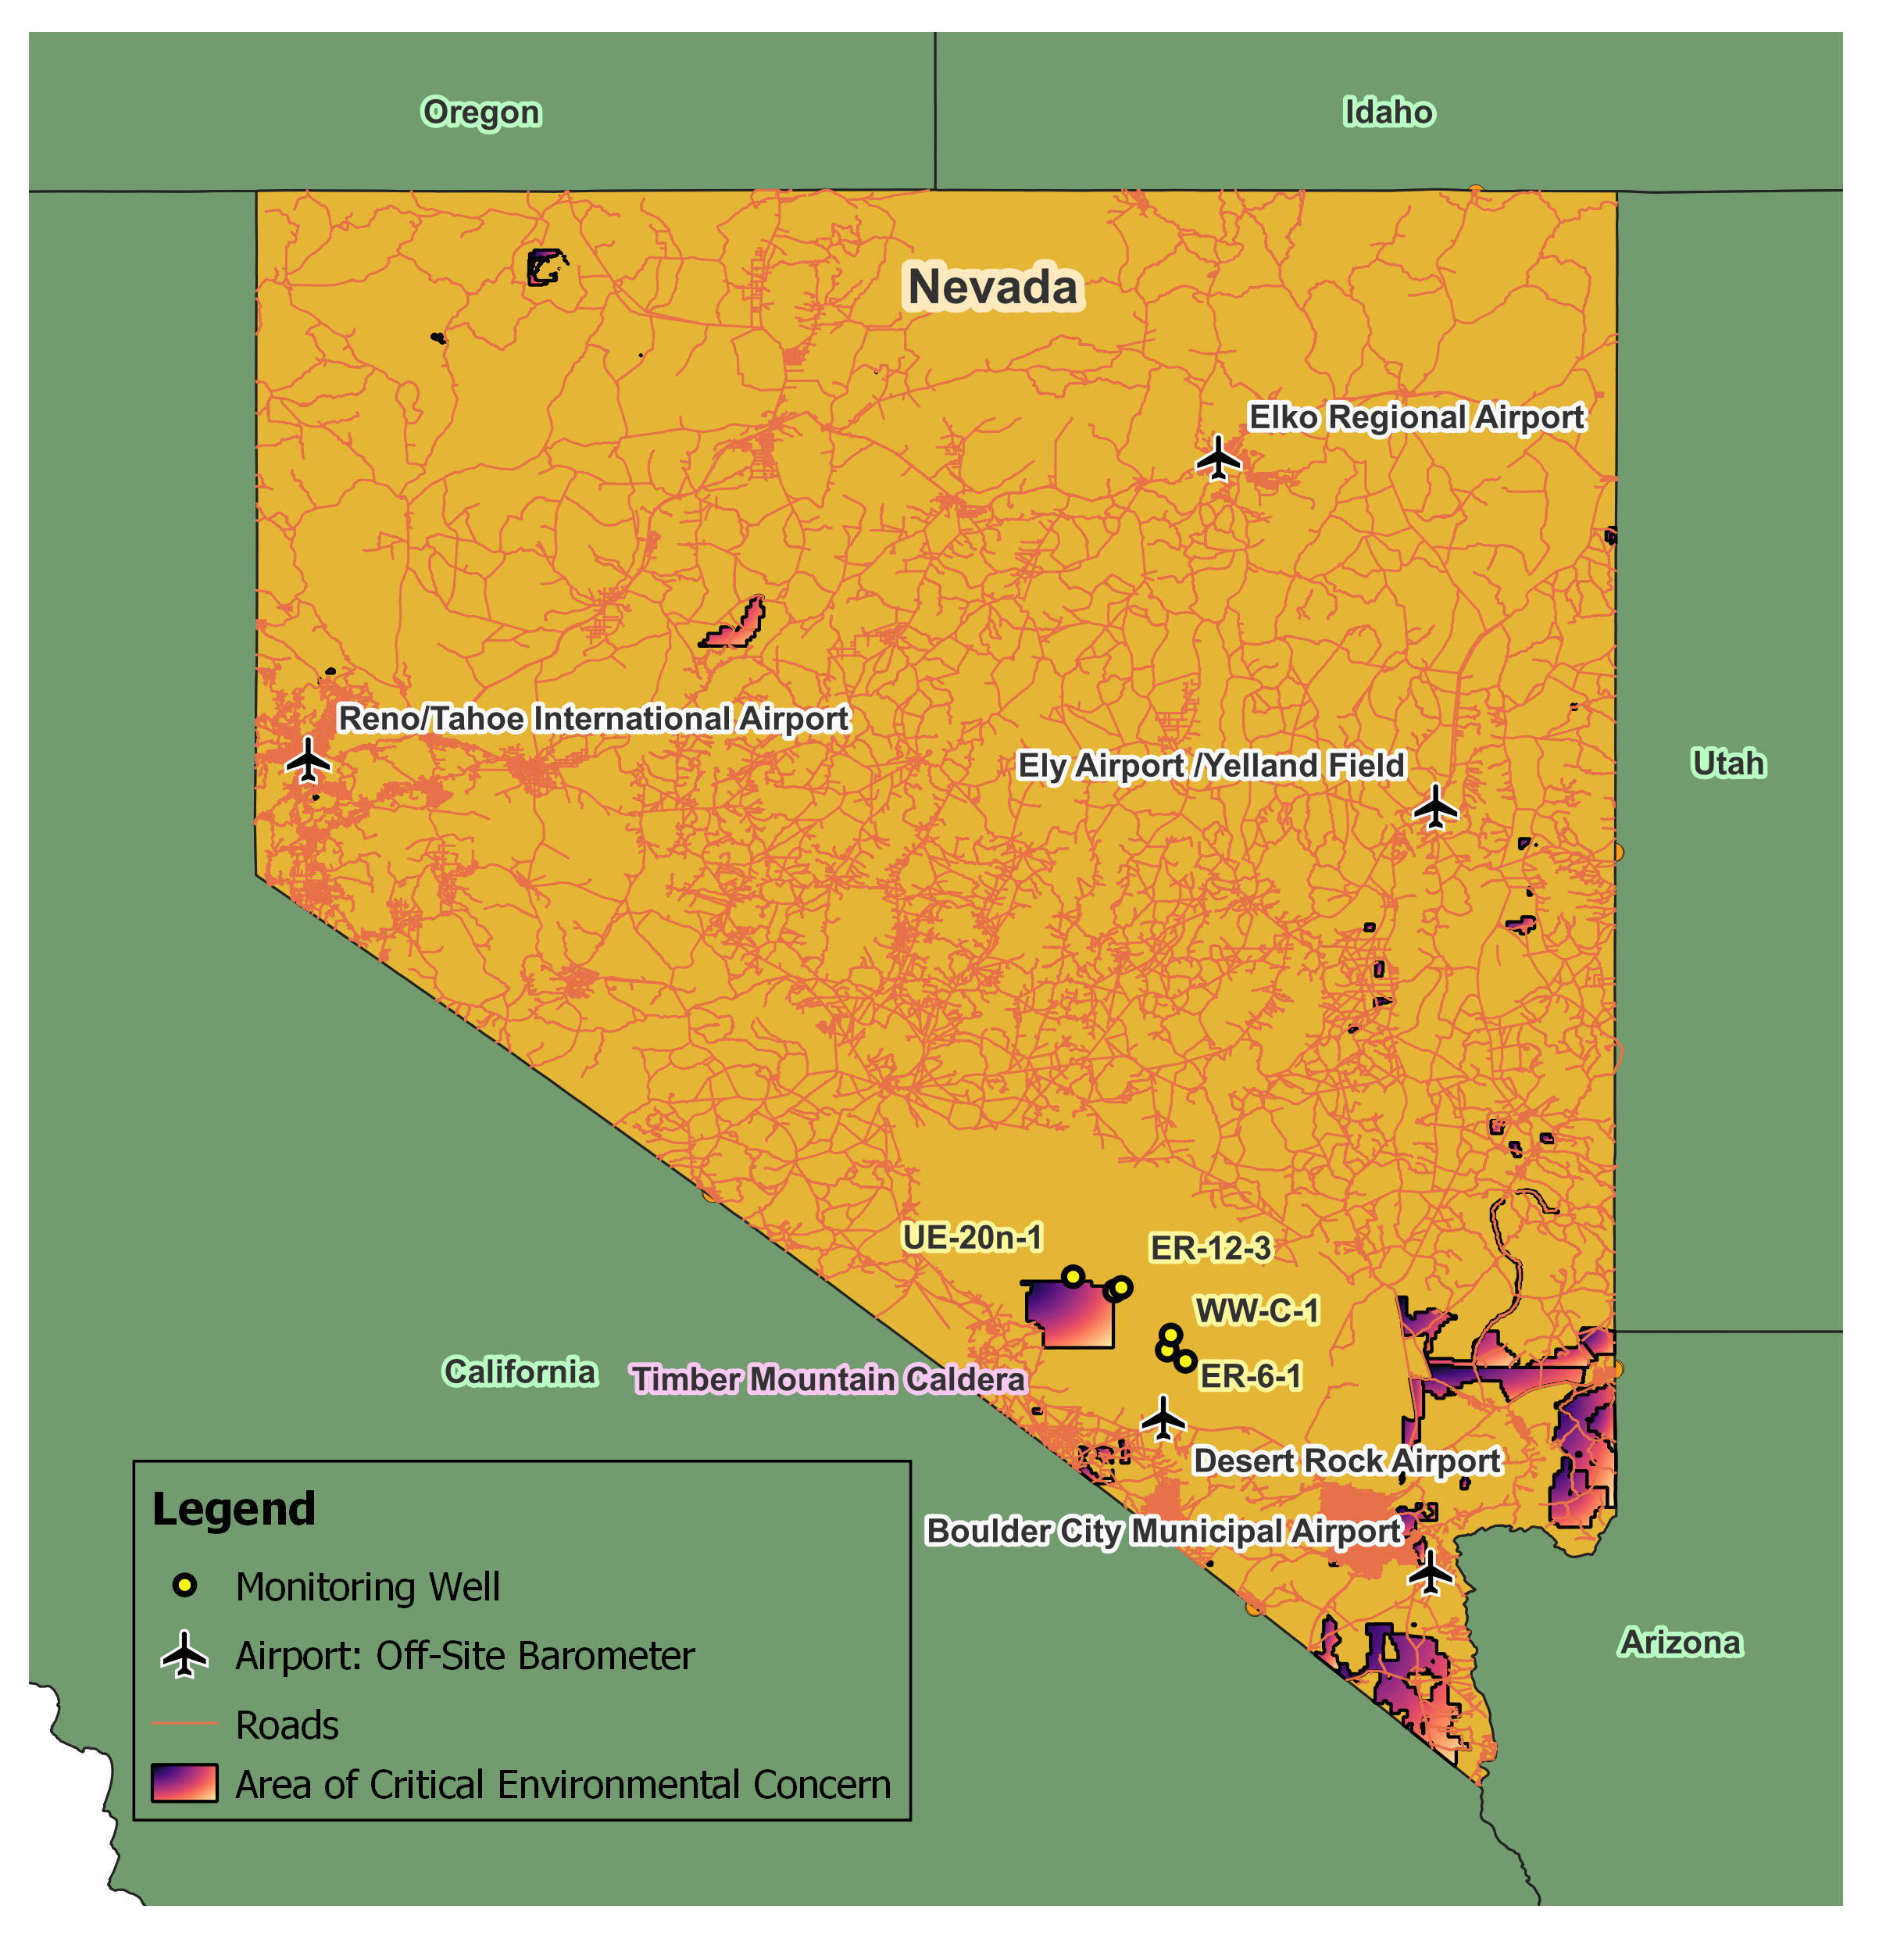

In [3]:
# site map

from IPython.display import Image, display
display(Image(filename='fig1_map.png'))

__Datasets:__ Groundwater records from Nye County, Nevada were obtained from the United States Geological Survey (USGS) National Water Information System (NWIS). NWIS datasets include records of both absolute pressure from unvented pressure transducer and uncorrected barometric pressure expressed in pounds per square inch (psi), compensated groundwater levels that are expressed in feet below land surface, and groundwater temperature in degrees Celsius. Off-site barometric records were obtained from the National Oceanic and Atmospheric Administration (NOAA) National Centers for Environmental Information (NCEI) Local Climatological Data (LCD) database. Data were obtained from airports in Boulder City, Desert Rock, Elko, Ely, and Reno, Nevada, and include records of atmospheric pressure in inches of mercury (inHg) and air temperature in degrees celcius.  All datasets provide the date and time for each measurement, station coordinates, and station elevation. 

In [6]:
#%% import python tools and specify parameters

import os
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

# relevant directories
cd = os.getcwd()

#%% specify parameters

trans_locs =  ['ER-5-5','WW-C-1','ER-6-1','ER-19-1-3','ER-12-3','UE-20n-1']   # monitoring well IDs               
baro_locs =  ['Boulder City','Desert Rock','Elko','Ely','Reno']              # baro station locations
baro_locs2 =  ['Boulder City','Desert Rock','Elko','Ely','Reno', "On-Site"] # include on-site
initials = ['bc','dr','elko','ely','reno']                                # baro station initials
initials2 = ['bc','dr','elko','ely','reno','on']                       # include on-site
params = ['diff','elev','temp','t_diff','baro','dist','comp'] # parameters of interest

# load off-site station porperties: differences in distance and elevation 
# between each Monitoring Well and Off-site Barometer
# see input file for format
props = pd.read_csv(cd+'\\'+'props_input.csv')

In [7]:
#%% Load NOAA Data

dir_data_baro = '\data\\baro-Noaa'
baronames= os.listdir(cd+dir_data_baro)

baro_dfs ={}
for dfn,file in zip(initials, baronames):
    baro_dfs['baro_'+dfn] = pd.read_csv(cd+dir_data_baro+'\\'+file, 
                                        parse_dates=['DATE'], index_col=['DATE'], 
                                        na_values=['-99.9'],usecols=['DATE','HourlyStationPressure','HourlyDryBulbTemperature'],
                                        low_memory=False)

for init in initials:
    baro_dfs['baro_'+init]=baro_dfs['baro_'+init].rename(columns={'HourlyStationPressure':'baro_'+init,
                                                                  'HourlyDryBulbTemperature':'temp_'+init})
    baro_dfs['baro_'+init]['baro_'+init]=pd.to_numeric(baro_dfs['baro_'+init]['baro_'+init], errors='coerce')
    baro_dfs['baro_'+init]['temp_'+init]=pd.to_numeric(baro_dfs['baro_'+init]['temp_'+init], errors='coerce')
    baro_dfs['baro_'+init]['baro_'+init]=baro_dfs['baro_'+init]['baro_'+init]*0.49115415222661
    baro_dfs['baro_'+init]=baro_dfs['baro_'+init].interpolate(method='linear')
    baro_dfs['baro_'+init]=baro_dfs['baro_'+init].resample('H').mean()

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'C:\\Users\\jetry\\data\\baro-Noaa'

In [8]:
#%% Load USGS data

dir_data_trans = '\data\\trans-Usgs'
dir_data_ontrans = '\data\\baro-Usgs'
dir_data_ontemp = '\data\\temp-Usgs'
dir_data_wl = '\data\\wl-Usgs'

transnames= os.listdir(cd+dir_data_trans)
ontransnames= os.listdir(cd+dir_data_ontrans)
ontempnames= os.listdir(cd+dir_data_ontemp)
wlnames= os.listdir(cd+dir_data_wl)

# load absolute transducer pressure files
trans_dfs ={}
for dfn,file in zip(trans_locs, transnames):
    trans_dfs[dfn] = pd.read_csv(cd+dir_data_trans+'\\'+file, sep='\t', parse_dates=['20d'],index_col=['20d'],
                                 na_values=['-99.9'], comment ='#', header=1, usecols=['20d','14n'])

for name in trans_locs:
    trans_dfs[name]=trans_dfs[name].rename(columns={'14n':'p_abs'})    

# load on-site barometric pressure files
for name,file in zip(trans_locs, ontransnames):
    trans_dfs[name]['baro_on'] = pd.read_csv(cd+dir_data_ontrans+'\\'+file, sep='\t', 
                                            na_values=['-99.9'], parse_dates=['20d'], 
                                            index_col=['20d'],comment ='#', header=1, usecols=['20d','14n'])

# load on-site temperature files
for name,file in zip(trans_locs, ontempnames):
    trans_dfs[name]['temp_on'] = pd.read_csv(cd+dir_data_ontemp+'\\'+file, sep='\t', na_values=['-99.9'],
                                            parse_dates=['20d'], index_col=['20d'],
                                            comment ='#', header=1, usecols=['20d','14n'])

# load USGS reported water levels
wl_dfs={}
for name,file in zip(trans_locs, wlnames):
    wl_dfs[name] = pd.read_csv(cd+dir_data_wl+'\\'+file, sep='\t', 
                               na_values=['-99.9'], comment ='#', header=1, 
                               usecols=['20d','14n'],parse_dates=['20d'], index_col=['20d'])\

for name in trans_locs:
    wl_dfs[name]=wl_dfs[name].rename(columns={'14n':'usgs_wlbl'})
    wl_dfs[name]=wl_dfs[name].resample('H').mean()

__Plots Of Raw Data:__ The next three sections of code plot the raw data records. Several anomalies are present; including data gaps, spikes, and time-series offsets. Dynamic or potentially anomalous sections of compensated data, identifiable in results section plots, can be compared to these records to understand the relationships between various parameters and conditions.

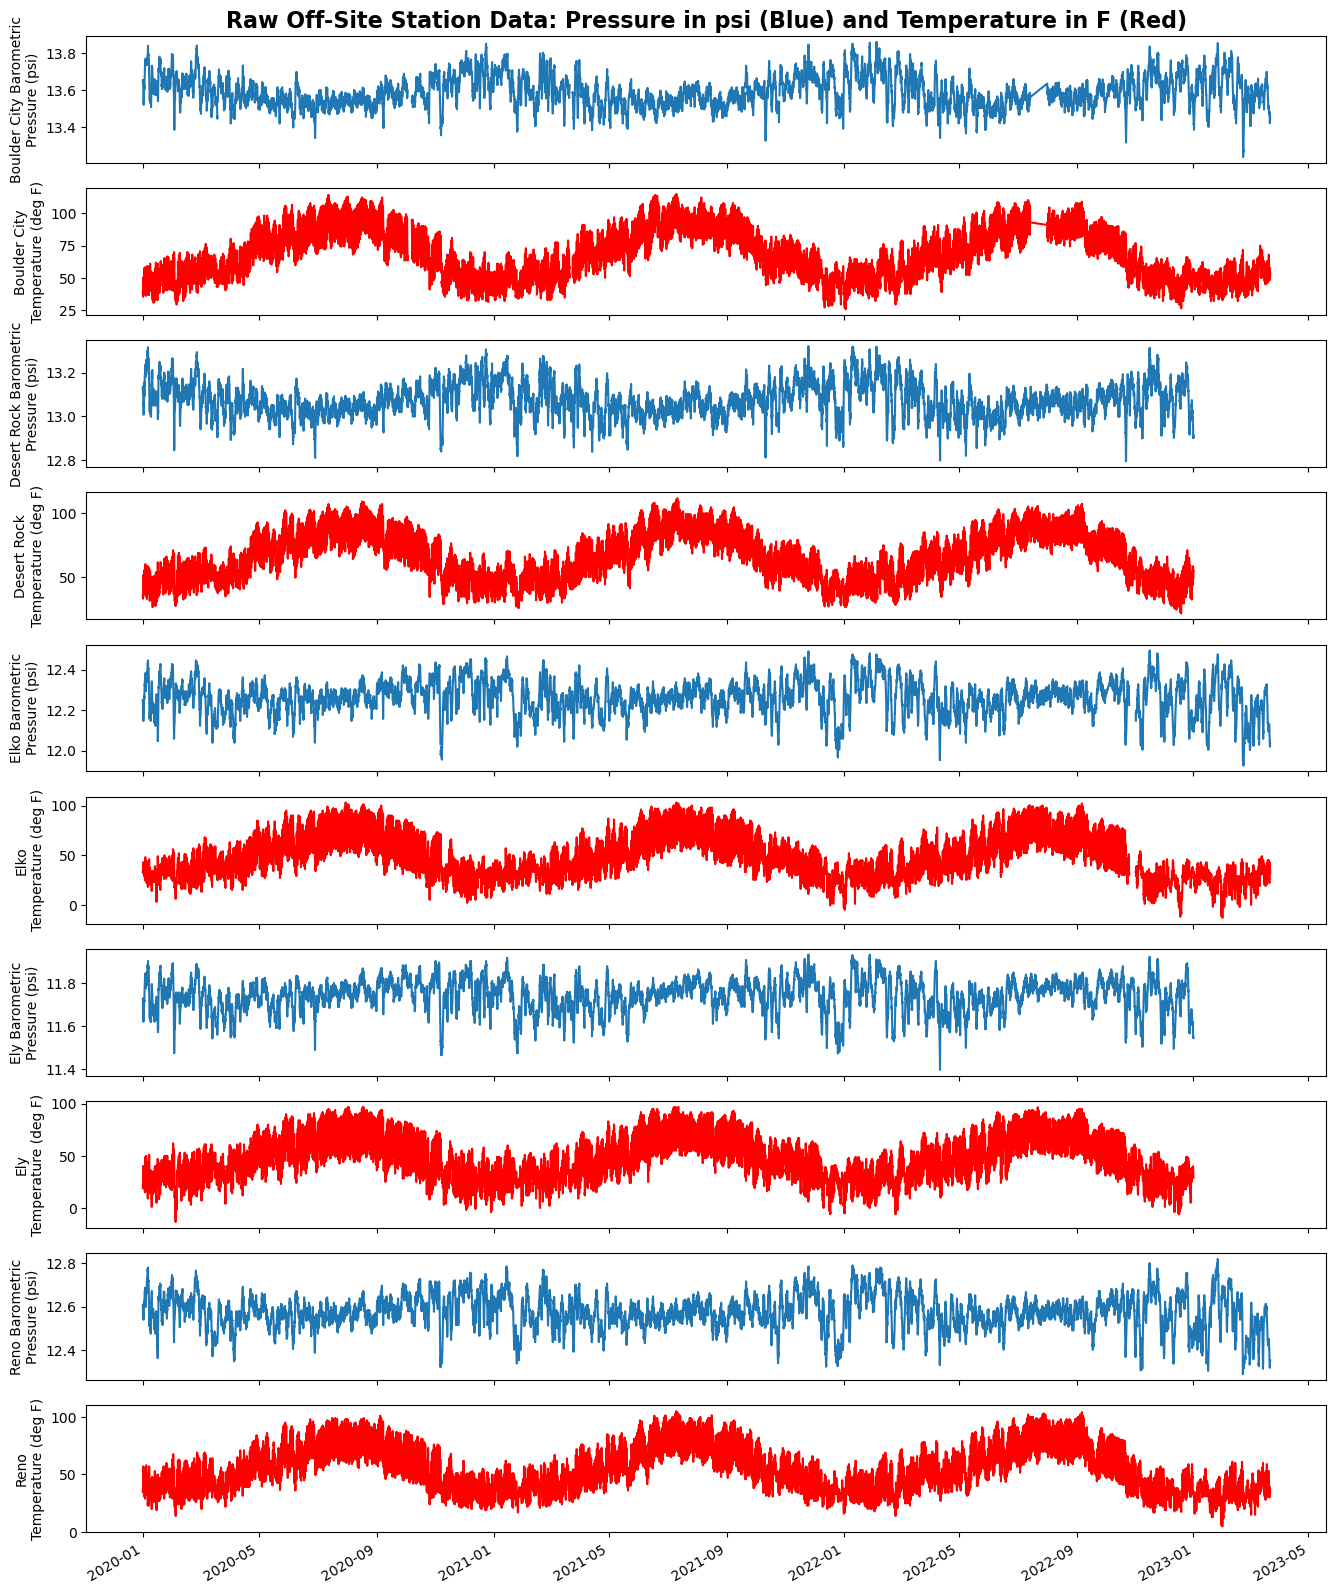

In [10]:
#%% plot raw data

# plot Off-Site barometric records
fig,ax=plt.subplots(nrows=10,ncols=1,sharex=True,figsize = (16,22))
ax[0].plot(baro_dfs['baro_bc']['baro_bc'])
ax[1].plot(baro_dfs['baro_bc']['temp_bc'],'r-')
ax[2].plot(baro_dfs['baro_dr']['baro_dr'])
ax[3].plot(baro_dfs['baro_dr']['temp_dr'],'r-')
ax[4].plot(baro_dfs['baro_elko']['baro_elko'])
ax[5].plot(baro_dfs['baro_elko']['temp_elko'],'r-')
ax[6].plot(baro_dfs['baro_ely']['baro_ely'])
ax[7].plot(baro_dfs['baro_ely']['temp_ely'],'r-')
ax[8].plot(baro_dfs['baro_reno']['baro_reno'])
ax[9].plot(baro_dfs['baro_reno']['temp_reno'],'r-')
ax[0].set_ylabel('Boulder City Barometric\nPressure (psi)')
ax[1].set_ylabel('Boulder City\nTemperature (deg F)')
ax[2].set_ylabel('Desert Rock Barometric\nPressure (psi)')
ax[3].set_ylabel('Desert Rock\nTemperature (deg F)')
ax[4].set_ylabel('Elko Barometric\nPressure (psi)')
ax[5].set_ylabel('Elko\nTemperature (deg F)')
ax[6].set_ylabel('Ely Barometric\nPressure (psi)')
ax[7].set_ylabel('Ely\nTemperature (deg F)')
ax[8].set_ylabel('Reno Barometric\nPressure (psi)')
ax[9].set_ylabel('Reno\nTemperature (deg F)')
ax[0].set_title('Raw Off-Site Station Data: Pressure in psi (Blue) and Temperature in F (Red)',
                fontweight='bold',fontsize=16)
plt.gcf().autofmt_xdate()





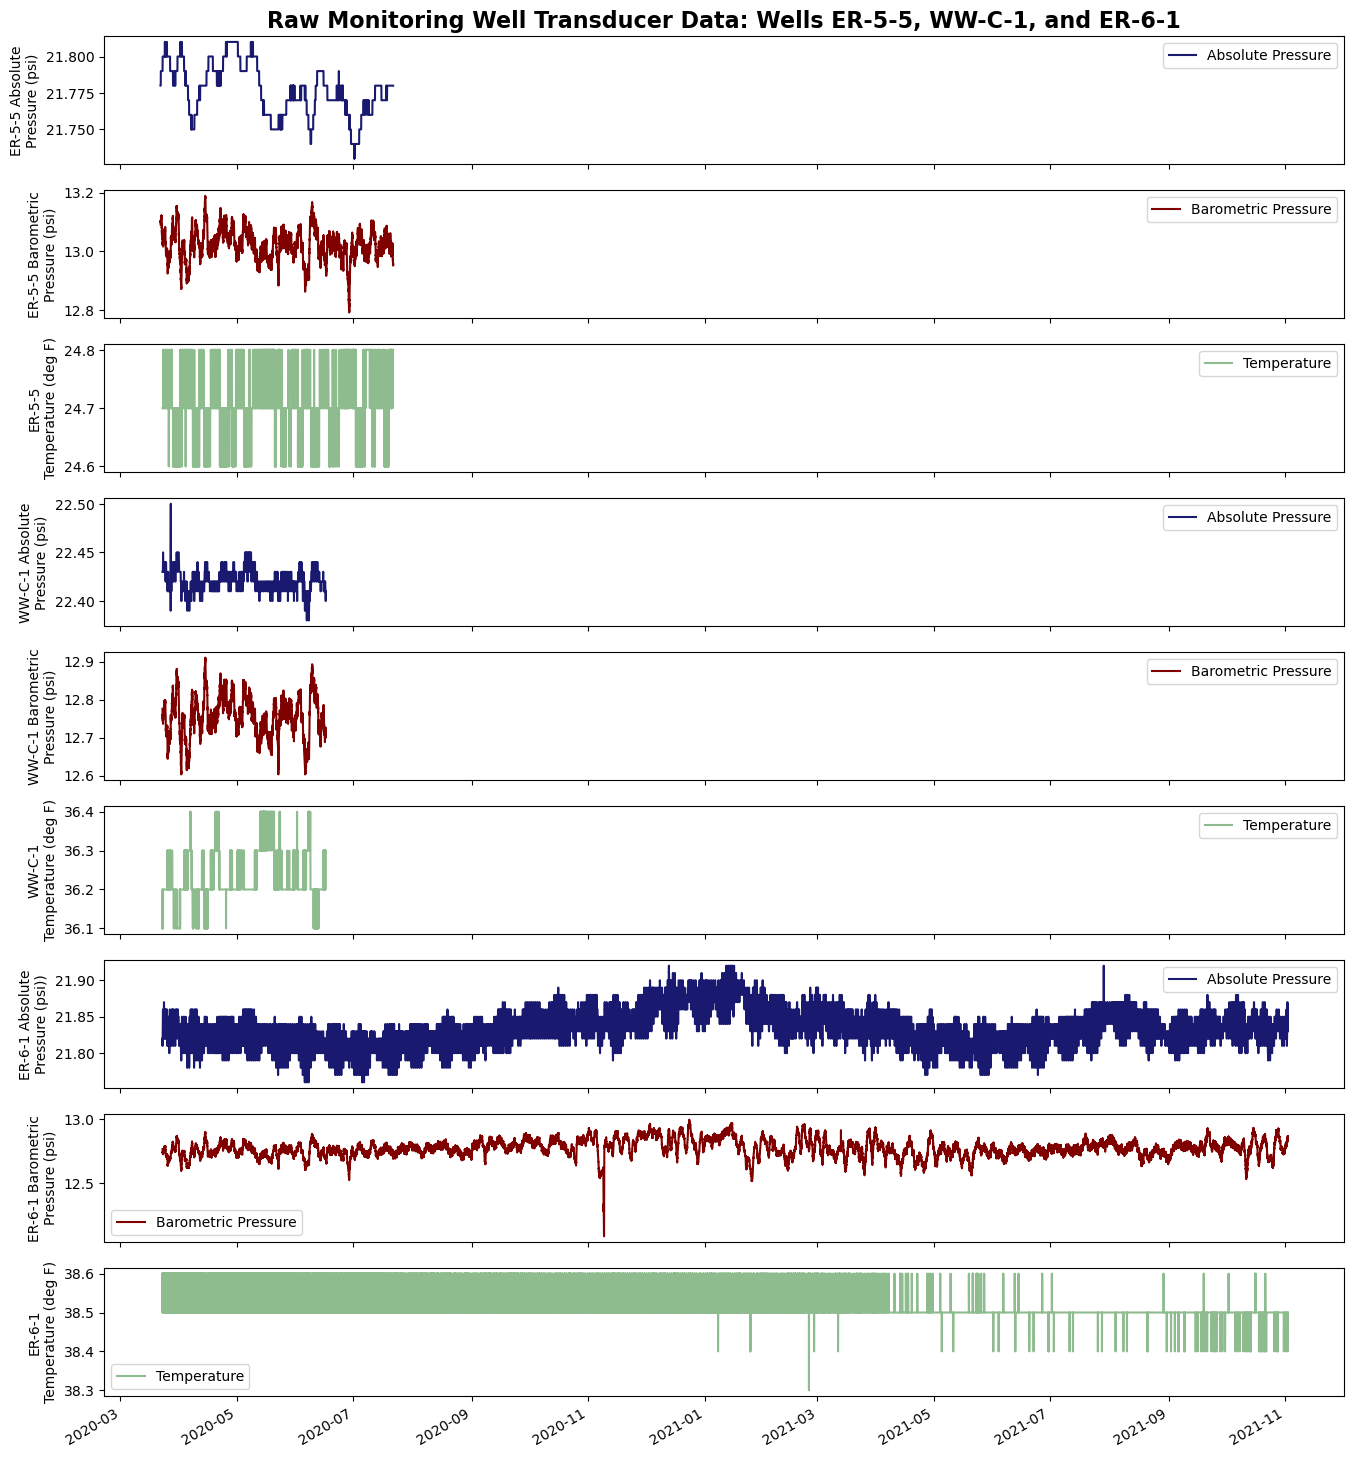

In [11]:
# plot on-site transducer records from locations 1-3
fig,ax=plt.subplots(nrows=9,ncols=1,sharex=True,figsize = (16,20))
ax[0].plot(trans_dfs[trans_locs[0]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[1].plot(trans_dfs[trans_locs[0]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[2].plot(trans_dfs[trans_locs[0]]['temp_on'],color='darkseagreen',label='Temperature')
ax[3].plot(trans_dfs[trans_locs[1]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[4].plot(trans_dfs[trans_locs[1]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[5].plot(trans_dfs[trans_locs[1]]['temp_on'],color='darkseagreen',label='Temperature')
ax[6].plot(trans_dfs[trans_locs[2]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[7].plot(trans_dfs[trans_locs[2]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[8].plot(trans_dfs[trans_locs[2]]['temp_on'],color='darkseagreen',label='Temperature')
ax[0].set_ylabel(f'{trans_locs[0]} Absolute\nPressure (psi)')
ax[1].set_ylabel(f'{trans_locs[0]} Barometric\nPressure (psi)')
ax[2].set_ylabel(f'{trans_locs[0]}\nTemperature (deg F)')
ax[3].set_ylabel(f'{trans_locs[1]} Absolute\nPressure (psi)')
ax[4].set_ylabel(f'{trans_locs[1]} Barometric\nPressure (psi)')
ax[5].set_ylabel(f'{trans_locs[1]}\nTemperature (deg F)')
ax[6].set_ylabel(f'{trans_locs[2]} Absolute\nPressure (psi))')
ax[7].set_ylabel(f'{trans_locs[2]} Barometric\nPressure (psi)')
ax[8].set_ylabel(f'{trans_locs[2]}\nTemperature (deg F)')
for i in range(9):
    ax[i].legend(loc='best')
ax[0].set_title(f'Raw Monitoring Well Transducer Data: Wells {trans_locs[0]}, {trans_locs[1]}, and {trans_locs[2]}',
                fontweight='bold',fontsize=16)
plt.gcf().autofmt_xdate()


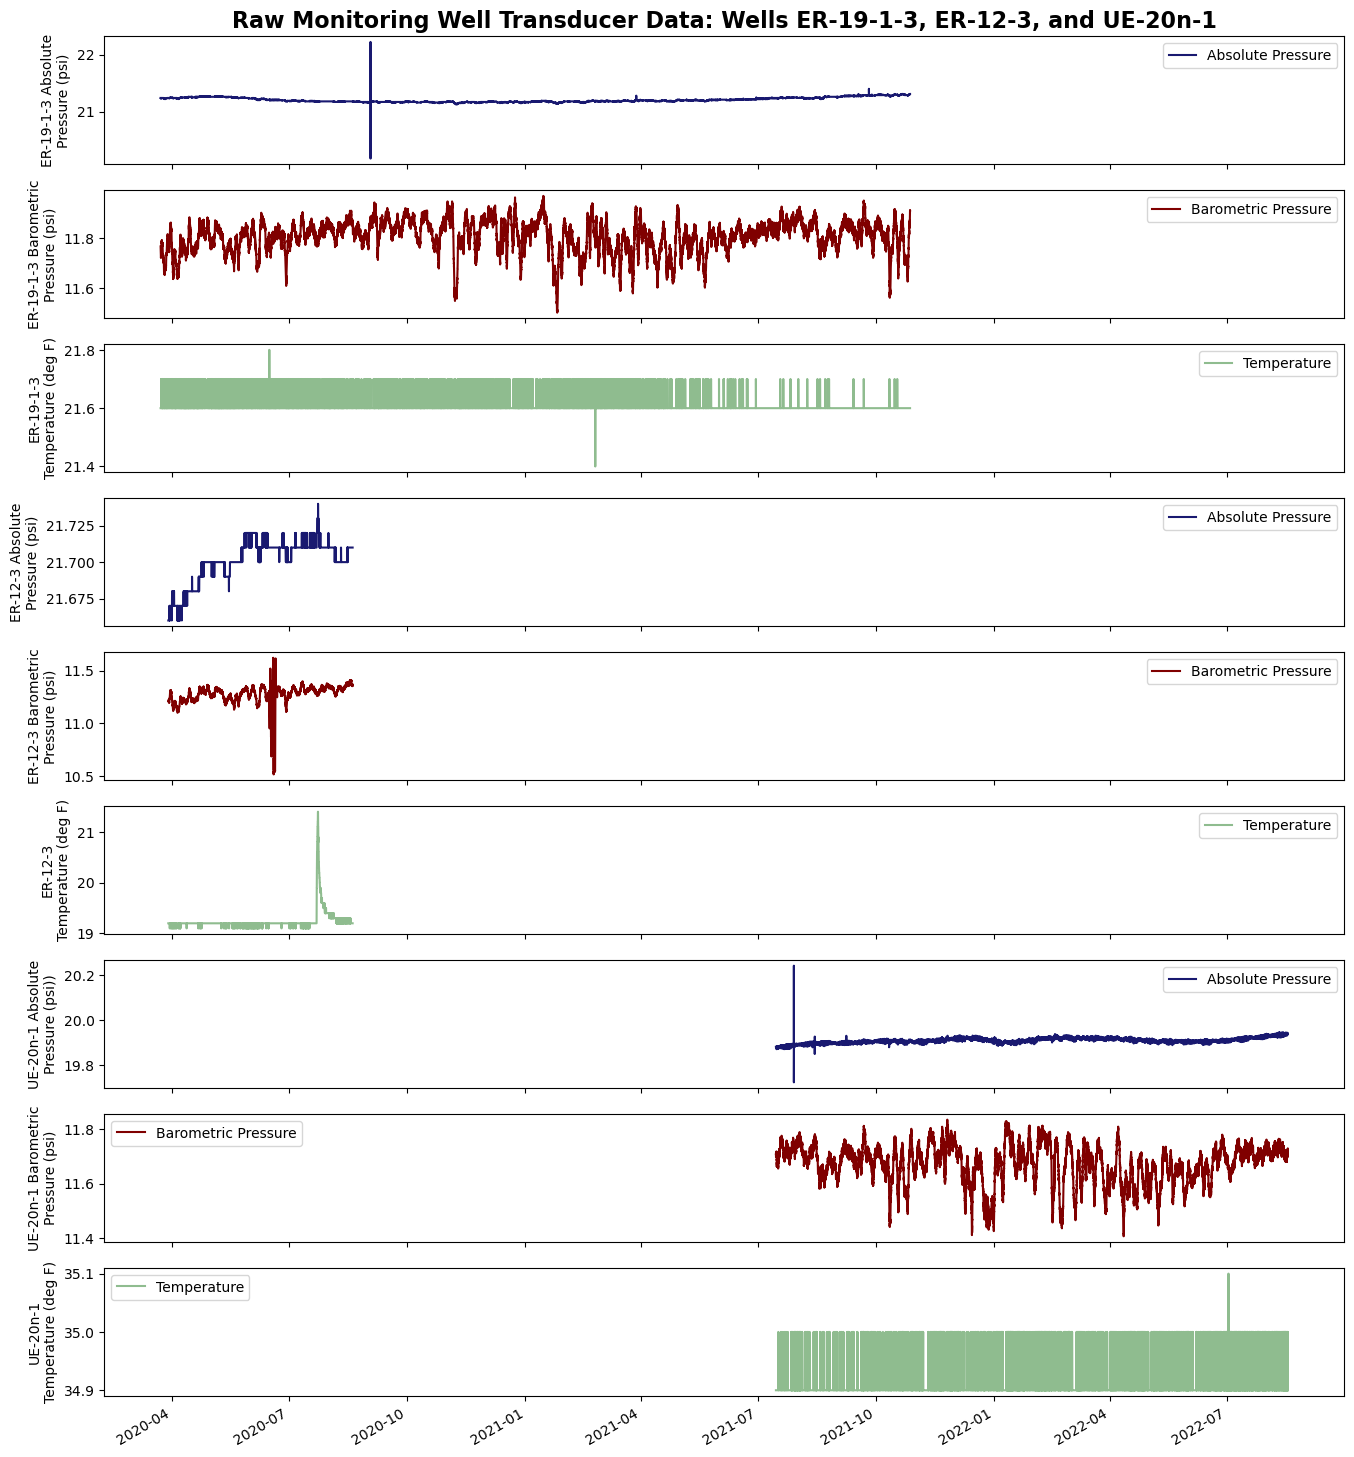

In [12]:
# plot raw transducer records from locations 3-6

fig,ax=plt.subplots(nrows=9,ncols=1,sharex=True,figsize = (16,20))
ax[0].plot(trans_dfs[trans_locs[3]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[1].plot(trans_dfs[trans_locs[3]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[2].plot(trans_dfs[trans_locs[3]]['temp_on'],color='darkseagreen',label='Temperature')
ax[3].plot(trans_dfs[trans_locs[4]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[4].plot(trans_dfs[trans_locs[4]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[5].plot(trans_dfs[trans_locs[4]]['temp_on'],color='darkseagreen',label='Temperature')
ax[6].plot(trans_dfs[trans_locs[5]]['p_abs'],color='midnightblue',label='Absolute Pressure')
ax[7].plot(trans_dfs[trans_locs[5]]['baro_on'],color='maroon',label='Barometric Pressure')
ax[8].plot(trans_dfs[trans_locs[5]]['temp_on'],color='darkseagreen',label='Temperature')
ax[0].set_ylabel(f'{trans_locs[3]} Absolute\nPressure (psi)')
ax[1].set_ylabel(f'{trans_locs[3]} Barometric\nPressure (psi)')
ax[2].set_ylabel(f'{trans_locs[3]}\nTemperature (deg F)')
ax[3].set_ylabel(f'{trans_locs[4]} Absolute\nPressure (psi)')
ax[4].set_ylabel(f'{trans_locs[4]} Barometric\nPressure (psi)')
ax[5].set_ylabel(f'{trans_locs[4]}\nTemperature (deg F)')
ax[6].set_ylabel(f'{trans_locs[5]} Absolute\nPressure (psi))')
ax[7].set_ylabel(f'{trans_locs[5]} Barometric\nPressure (psi)')
ax[8].set_ylabel(f'{trans_locs[5]}\nTemperature (deg F)')
for i in range(9):
    ax[i].legend(loc='best')
ax[0].set_title(f'Raw Monitoring Well Transducer Data: Wells {trans_locs[3]}, {trans_locs[4]}, and {trans_locs[5]}',
                fontweight='bold',fontsize=16)
plt.gcf().autofmt_xdate()

METHODS - Data Processing and Analysis

Below is a function that parses barometric records according to the date range of each individual transducer. DataFrames are created for each transducer and stored in a dictionary called "trans_dfs".

These DataFrames include the following columns:

baro_i: barometer pressure at Off-Site station [i],  
temp_i: temperature at Off-Site station [i],  
comp_i: compensated groundwater depth using barometric record from off-site station[i],  
diff_i: difference in compensation output between use of on-site and off-site station [i] barometers,  
t_diff_i: difference in temperature between off-site station [i] and transducer at measurement time,  
dist_i: distance between monitoring location and off-site station [i],  
elev_i: difference in elevation between monitoring location and off-site station [i],  
month: month of measurement.  
          NOTE: this was not used for the current analysis, however this allows the user to parse the                    results DataFrame by month or season to compare regression results if desired.  
          
The compensation formula is identified by comment in the section below, and creates a series that relates all pressure (absolute and barometer) changes to the first reported water level, converts them from psi to feet of water, and inverts them so increasingly positive values represent increasing depth to the water surface. In the following plots, y-axis magnitude increases from top to bottom so that water level dynamics are presented as they would be viewed in cross-section.

In [ ]:
# Analysis function
def barocomp(trans_dfs,wl_dfs,props,params):
    """
    This funciton uses pressure readings and reported water levels to barometrically 
    compensate groundwater data and calibrate them to the first reported wate level.
    Relative station properties are added and a DataFrame is generated that indexes 
    properties to compensation output difference between off-site and on-site barometers.
    
    trans_dfs: Dict of DataFrames withtTransducer and barometer records
    
    wl_dfs: Dict of DataFrames with reported Water Levels below Land Surface
               
    props: DataFrame with differences in elevation and temp between Off-Site and On-Site Stations
             ** See input file for format
                           
    params: List of parameters of interest for regression analyses
    """
    results_temp= {}
    results_dfs = {}
    results=pd.DataFrame()
    temp={}
    trans_monthly={}
    for name in trans_locs:
        trans_dfs[name]=trans_dfs[name].resample('H').mean()
        trans_dfs[name]=trans_dfs[name].interpolate(method='linear')
        
# compensate transducer pressure readings: calibrate to 1st reported WL and convert to feet of water
            
        trans_dfs[name]['comp_on']=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'baro_on']-trans_dfs[name]['baro_on'])*2.31)
        for init in initials:
            
# trim off-site records to transducer data extent, compensate and calculate differences
                
            trans_dfs[name]['baro_'+init]=baro_dfs['baro_'+init]['baro_'+init][trans_dfs[name].index[0]:trans_dfs[name].index[-1]]
            trans_dfs[name]['temp_'+init]=baro_dfs['baro_'+init]['temp_'+init][trans_dfs[name].index[0]:trans_dfs[name].index[-1]]
            trans_dfs[name]['comp_'+init]=wl_dfs[name].usgs_wlbl[0] + ((trans_dfs[name].loc[trans_dfs[name].index[0],'p_abs']-trans_dfs[name]['p_abs'])*2.31) - ((trans_dfs[name].loc[trans_dfs[name].index[0],'baro_'+init]-trans_dfs[name]['baro_'+init])*2.31)
            trans_dfs[name]['diff_'+init]=abs(trans_dfs[name]['comp_'+init]-trans_dfs[name]['comp_on'])
            trans_dfs[name]['t_diff_'+init]=abs(trans_dfs[name]['temp_'+init]-trans_dfs[name]['temp_on'])
            trans_dfs[name]['t_diff_'+init]=trans_dfs[name]['t_diff_'+init].interpolate(method='linear')
            
# add reported water levels, station distances, and elevation differences to each DataFrame
            
        trans_dfs[name]['wlbl_usgs']=wl_dfs[name]['usgs_wlbl'].copy()
        trans_dfs[name]['dist_bc']=props[name][0]
        trans_dfs[name]['elev_bc']=abs((props[name][1]))
        trans_dfs[name]['dist_dr']=props[name][2]
        trans_dfs[name]['elev_dr']=abs(props[name][3])
        trans_dfs[name]['dist_elko']=props[name][4]
        trans_dfs[name]['elev_elko']=abs(props[name][5])
        trans_dfs[name]['dist_ely']=props[name][6]
        trans_dfs[name]['elev_ely']=abs(props[name][7])
        trans_dfs[name]['dist_reno']=props[name][8]
        trans_dfs[name]['elev_reno']=abs(props[name][9])
        trans_dfs[name]['month']=trans_dfs[name].index.month  
        
            # resample to weekly averages
            
        trans_monthly[name]=trans_dfs[name].resample('W-MON').mean().interpolate()
        
            # compile results dfs with target parameters from each location
            
        results_dfs[name]=pd.DataFrame()
        for param in params:
            results_temp[param]=pd.DataFrame()
            for init in initials:
                temp[param]=trans_monthly[name][param+'_'+init]
                results_temp[param]=pd.concat([results_temp[param],temp[param]])
            results_temp[param].rename(columns={0:param},inplace=True)
            results_temp[param].sort_index(inplace=True)
            results_dfs[name][param]=results_temp[param][param]     
            
    # compile master results DataFrame and index by output difference
    
        results=pd.concat([results,results_dfs[name]])    
    results['month']=results.index.month    
    results.reset_index(inplace=True)
    results.set_index('diff',inplace=True)
    results.drop(columns=['index'],inplace=True)
    
    # return results DataFrame
    
    return results

METHODS - Plotting Functions

Data are plotted in multiple ways to analyze the results of the compensations and regressions. First, individual plots are generated for each location that show all the compensated time-series in stacked plots. The on-site compensation data are visually distinct so they can easily be compared to the reported water levels and subsequent off-site calibrations, allowing for confirmation that the compensations were both performed correctly. Subsequent plotting functions are listed in the same code block, with their individual outputs and parameters identified in docstrings.

In [3]:
# functions for plotting figures

def plotbarocomps(dfs,sta_num,sta_locs):
    """
    This function plots the results of barometric compensation, one figure 
    per monitoring location, each with stacked plots presenting the reported water
    levels in the top panel, the results of compensation using the on-site barometric 
    record, and then panels for compensation output from each off-site barometer. 
    
    dfs: Dict of DataFrames with compensated outputs indexed to date-time
    
    sta_num: Int number of off-site barometer stations analyzed
    
    sta_locs: List of string values for Monitoring Well location ID's
    """
    rows=sta_num+2
    colors=['maroon','cadetblue','darkcyan','teal','steelblue','royalblue']
    y={}
    for name in trans_locs:
        fig,ax=plt.subplots(nrows=rows,ncols=1,sharex=True,figsize = (8,10),tight_layout=True)
        ax[0].set_title(f'Groudnwater Levels in Monitoring Well {name}\nResults of Raw Data Compensation from Each Barometer',
                       fontsize=14,fontweight='bold')
        fig.supylabel('Groundwater Levels Below Land Surface',fontweight='bold')
        ax[0].plot(dfs[name].index,dfs[name].wlbl_usgs,'k-',label='USGS Reported Water Levels')
        y = ax[0].get_ylim()
        ax[0].set_ylim(y[0]-(0.00025*y[0]),y[1]+(0.00025*y[1]))
        ax[0].set_ylim(ax[0].get_ylim()[::-1])
        ax[0].set_ylabel('(feet)')
        ax[0].legend(loc='best',prop={'size': 7})
        for i in range(0,rows-1):
            ax[i+1].plot(dfs[name].index,dfs[name]['comp_'+initials2[i-1]],color=colors[i],label=sta_locs[i-1]+' Compensation')
            
            ax[i+1].set_ylim(y[0]-(0.00025*y[0]),y[1]+(0.00025*y[1]))
            ax[i+1].set_ylim(ax[i+1].get_ylim()[::-1])
            ax[i+1].set_ylabel('(feet)')
            ax[i+1].legend(loc='best',prop={'size': 7})    
        plt.gcf().autofmt_xdate()
        plt.show()
            
# Regressions
def regplotcomps(df):
    """
    This function creates scatter plots of the difference in compensation
    output versus each of the target parameters. Linear and Thiel-Sen regression
    are performed on each reltionship to test for correlation and significant 
    relationships. Outliers values were left in the DataFrames, as they are valuable
    for equipment and data evaluation, and dealt with by applying both parametric and 
    non-parametric regressions. Anomalous data can be reviewed in multiple ways using 
    the subsequent plotting functions.
    
    df: DataFrame of target parameters indexed to compensation output difference
    """
    rows=6
    fig,ax=plt.subplots(nrows=rows,ncols=1,sharex=True,figsize = (15,12),tight_layout=True)
    fig.supylabel('Off-Site Station Property',fontsize=14, fontweight='bold')
    dict_keys = df.columns
    colors=['maroon','steelblue','darkslategrey','goldenrod','midnightblue','g']
    ylabels=['Elevation Difference\n(feet)','Absolute Temperature\n(deg F)',
             'Temperature\nDifference (deg F)','Barometric Pressure\n(feet of water)',
             'Distance to\nStudy Area (feet)','On-Site Groundwater\nDepth (feet)']
    x=df.index.values
    lsq_coeff={}
    sen_coeff={}
    tau={}
    xx={}
    yy={}
    for i in range(rows):
        ax[i].scatter(df.index,df[dict_keys[i]], color=colors[i], ls='dotted',s=12, label='Weekly Averaged Compensation Difference')
        ax[i].set_ylabel(ylabels[i])
        lsq_coeff[i] = stats.linregress(x, df[dict_keys[i]])         # least squares coefficients
        sen_coeff[i] = stats.theilslopes(df[dict_keys[i]], x, 0.95)  # thiel-sen coefficients
        tau[i] = stats.kendalltau(x, df[dict_keys[i]])               # kendall tau test
        ax[i].plot(x, lsq_coeff[i].intercept + lsq_coeff[i].slope * x, 'k-', alpha=0.5, label='Linear regression')
        ax[i].plot(x, sen_coeff[i].intercept + sen_coeff[i].slope * x, color = 'indigo', alpha=0.5, label='Theil-Sen regression')
        ax[i].set_clip_on(False)   
        # annotate plot with regression slopes and correlation coefficients 
        xx[i] = ax[i].get_xlim()
        yy[i] = ax[i].get_ylim()    
        ax[i].annotate(f'Least-squares slope = {lsq_coeff[i].slope:.1f} +/- {2*lsq_coeff[i].stderr:.1f}',
                    xy=(xx[i][1]+.02*(xx[i][1]-xx[i][0]), yy[i][0] + 0.55*(yy[i][1]-yy[i][0])),
                    horizontalalignment='left',annotation_clip=False)
        ax[i].annotate(f'Least-squares correlation = {lsq_coeff[i].rvalue:.3f}; p = {lsq_coeff[i].pvalue:.6f}',
                    xy=(xx[i][1]+0.02*(xx[i][1]-xx[i][0]), yy[i][0] + 0.4*(yy[i][1]-yy[i][0])),
                    horizontalalignment='left',annotation_clip=False)
        ax[i].annotate(f'Theil-Sen slope = {sen_coeff[i].slope:.1f} +/- {0.5*(sen_coeff[i].high_slope - sen_coeff[i].low_slope):.1f}',
                    xy=(xx[i][1]+0.02*(xx[i][1]-xx[i][0]), yy[i][0] + 0.25*(yy[i][1]-yy[i][0])),
                    horizontalalignment='left',annotation_clip=False)
        ax[i].annotate(f'Tau correlation = {tau[i].correlation:.3f}; p = {tau[i].pvalue:.6f}',
                    xy=(xx[i][1]+0.02*(xx[i][1]-xx[i][0]), yy[i][0] + 0.1*(yy[i][1]-yy[i][0])),
                    horizontalalignment='left',annotation_clip=False)
        if i < 4:
            ax[i].legend(bbox_to_anchor=(1.01,1.0),prop={'size': 7})
        else:
            ax[i].legend(bbox_to_anchor=(1.275,1.0),prop={'size': 7})
        if i ==0:
            ax[i].set_title('Relationships between Compensation Ouput and Off-Site Station Property',
                            fontsize=18,fontweight='bold')           
    ax[5].set_xlabel('Average Weekly Difference in Compensation Output between Off-site and On-site Barometers (feet of water)',
                     fontsize=14,fontweight='bold')       
    plt.show()

def regionalwls(dfs,locs,startd,endd):
    """
    This function creates a stacked figure that displays the results of
    each compensation  at each monitoring location, with one panel for 
    each location and one line on each panel for each barometric record 
    used to compensate data. The start date and end date are programmable 
    so the user can inspect anomalies identified in any of the previous plots.
    
    dfs: Dict of DataFrames for each monitoring location with multiple compensation outputs
    
    locs: List of strings with monitoring location ID's
    
    startd: Datetime object of desired start date for plot
    
    endd: Datetime object of desired end date for plot
    """
    rows=len(dfs)
    fig,ax=plt.subplots(nrows=rows,ncols=1,sharex=True,figsize = (10,12))
    colors=['c','g','y','b','m','k']
    x={}
    y={}
    for i in range(rows):
        for j in range(len(initials2)):
            ax[i].plot(dfs[locs[i]].index,dfs[locs[i]]['comp_'+initials2[j]],
                       color=colors[j], label = baro_locs2[j]+' Barometer')
        ax[i].set_ylabel(locs[i]+'\nWater Levels\n(ft below ground)')
        ax[i].set_ylim(ax[i].get_ylim()[::-1])
        y[i] = ax[i].get_ylim()
        x[i] = ax[i].get_xlim()
        ax[i].set_ylim(y[i][0]-(0.000025*y[i][0]),y[i][1]+(0.000025*y[i][1]))
        ax[i].set_xlim(startd,endd)
            
    ax[0].legend(loc='best',prop={'size': 7.9})
    ax[5].annotate('Water Level Data Unavailable During this Period',xy=(x[5][0]+0.29*(x[5][1]-x[5][0]),
                                                                         y[5][0]+0.5*(y[5][1]-y[5][0])))     
    ax[0].set_title('Focus View of Water Levels During Period of\nOutlier Compensation Differences: Summer 2020',
                    fontsize=14,fontweight='bold')
    plt.gcf().autofmt_xdate()
    plt.show()

def anomalywls(dfs,loc,startd,endd):
    """
    This function plots all compensation results for a single monitoring 
    location over a defined date range. The on-site data are plotted as a 
    dotted line, so that off-site calibrations are viewable behind it when 
    the on-site barometer fails.
    
    dfs: Dict of DataFrames for each monitoring location with multiple compensation outputs
    
    loc: String of Monitoring Well ID with anomalous data. Must match dfs Dict Key
    
    startd: Datetime object of desired start date for plot
    
    endd: Datetime object of desired end date for plot
    """
    fig,ax = plt.subplots()
    ax.set_title('Focused View of Anomalous On-Site Barometer Output')
    colors=['c','g','y','b','m','k']
    styles=['-','-','-','-','-','dotted']

    for i in range(len(initials2)):
        ax.plot(dfs[loc].index,dfs[loc]['comp_'+initials2[i]],
                color=colors[i],ls=styles[i], label=baro_locs2[i]+' Baro')
    ax.set_xlim(startd,endd)
    ax.set_ylabel(f'{loc}\n(Water Levels)')
    ax.legend(loc='best',prop={'size': 9})
    ax.set_ylim(ax.get_ylim()[::-1])
    plt.gcf().autofmt_xdate()

RESULTS - Compensation

The lines of code in sections below execute the functions using loaded USGS and NOAA data. Note that any source data can be input, provided that they are compiled into dictionaries with DataFrames that contain the correct column headers.

In the following block, plotbarocomps() is used to generate a set of water level time-series for each monitoring location. Data from the on-site compensations very closely match the USGS reported water levels, with some linear offsetting that can be explained by using a single calibration point to anchor the data. If transducer position changes, or if reported water levels are calibrated to hand levels taken between measurements, copmensation output can be offset in a linear relationship to actual water levels. Data from the off-site calibrations generally follow similar trends as the on-site and reported calibrations. Differences in the seasonal impacts of off-site calibration can be most easily identified in the plot for Monitoring Well ER-19-1-3, where multiple long-term rates of water level rise are observed through the second half of 2020. There is also a muted water level rise, presumably due to precipitation, observed in the off-site compensations for Monitoring Well ER-6-1, as compared to the reported and on-site compensations. This is likely due to a localized low pressure system that occurred in concert with precipitation input to the aquifer. The records from off-site locations will not accurately capture groundwater dynamics during these conditions, which typically cannot be addressed by utilizing more calibration points. This represents a limitation in the use of off-site calibration that should be addressed whenever off-site calibration is used during storm periods.

Most notably, reported and on-site compensated water levels in ER-12-3 show a distinctly dynamic period that is not captured by the off-site compensations and appears anomolous. This period represents the outlier data points that are visible in each of the subsequent plots and is examined in the discussion figures.

In [ ]:
# execute analyses and plot results

results = barocomp(trans_dfs,wl_dfs,props,params)

fig1s=plotbarocomps(trans_dfs,5,baro_locs2)

RESULTS - Regressions

The following block generates a figure that displays the results of the data parsing and regressions. Parameters are presented from most to least significantly related to compensation output difference. Each of elvation difference, absolute temperature, temperature difference, and barometric pressure were corellated significantly with compensation output difference, and should be considered when choosing an off-site barometer for groundwater data compensation. Absolute temperature represents the temperature at the off-site location, while temperature difference represents the difference between the off-site temperature and the transducer (or groudnwater) temperature. Parameters are presented in descending order of the significance of their relationship with output difference. Of the significant parameters, elevation seems to be the most important. Not only are the correlations highest and p-values lowest, but the scatter plot does not exhibit as much noise across the lower range of values as temperature and temperature difference, or across the higher range of values like with barometric pressure. These results suggest that elevation of an off-site barometric record is the most important consideration when selecting one for groundwater data compensation.

In [ ]:
# execute analyses and plot results

fig2=regplotcomps(results)


DISCUSSION - Anomalies

The following block generates two figures that look at the outlier peried of Summer 2020. First is a plot of each station, with multiple lines depicting the various results of the different compensations. It is notable that some locations were typically overestimated, while others were underestimated, by the same barometers over the same time period. It is beyond the scope of this report to investigate possible reasons for this, but the presence of confining layers and locally distinct topographic features may influence these results. 

In the second figure, well ER-12-3 is examined by itself, as the reported and on-site compensation data are quite unusual for natural groundwater behavior. Given the more natural time series produced by the off-site barometers throughout the same time-period, and the dynamic raw data from the on-site barometer at this location, it is suspected that the barometer malfunctioned during this time period. It is possible that pressure and temperature fluctuations were recorded while the transducer was out of its typical setting for some reason, and is still working properly, but results like these would direct a groundwater professional to inspect the equipment and likely increase data collection frequency to ensure a continuous and dependable record. 

In [ ]:
# investigate anomalies in on-sitee barometer

startdate=pd.to_datetime('2020-05-01')
enddate=pd.to_datetime('2020-10-01')
fig3=regionalwls(trans_dfs,trans_locs,startdate,enddate)


startdate2=pd.to_datetime('2020-06-01')
enddate2=pd.to_datetime('2020-07-15')
fig4=anomalywls(trans_dfs,'ER-12-3',startdate2,enddate2)

DISCUSSION - Questions:

Do any of the target parameters show a statistically significant impact on the output when using off-site air presure data for barometric compensation?

    Yes, with station elevation being the most significant. Temperature and barometric pressure were also significantly related to compensation output.
    
Is there any seasonal variation to these impacts?
    
    Seasonal variation was not directly tested, however the period of time with both the largest continuous data output differences and the most anomolous readings, both occured during the late-spring to early-summer
    
How do variations in compensation output compare with magnitudes of natural water level fluctuation in the wells?

    Off-site compensation outputs are typically within 0.3 feet of the reported measurement. It is important to note that groundwater levels typically exceed 1000' in this study site, however groudnwater depth was not shown to be statistically significant to compensation output, though there was a slight negative correlation. In other study areas and project contexts, 0.3' can be quite significant. In these cases, the ability to apply an off-site compensation correction factor, based on specific off-site station properties, could potentially increase the resolution of modeling and other analytical outputs.
    
How could a groundwater professional use these results and interpretations to overcome project challenges such as damaged/failed equipment or budget limitations?

    A groundwater professional could use these results to make informed off-site barometer selction decisions when faced with a lack of on-site barometric data availability. Alternative approaches like using the closest record, easiest record to access, or simply using a constant value of approximately 34 feet of water do not provide any statistical support for their implementation, while this study used a regression analysis to test parameter influence.
    

DISCUSSION - Limitations and Future Work:

This study was limited in scope to one study area and to a duration of only two years. In part, this was due to the limited reporting of absolute pressure transducer by the USGS. Evaluating controls on barometric pressure dybamics were beyond the scope of this report, however selecting a suite of study areas based on a review of these controls would have helped increase the applicability of these results to other settings. Also, evaluating a longer data set that spanned multiple dry, wet, and average years would have allowed for a more robust analysis of the conditions that impact compensation output difference correllation between multiple barometers.

This study was also limited by looking at the full period of available records. Future work should include the review of results as they apply to different seasons and temperature conditions.

Finally, applying a correction to off-site compensaions based on the results was not tested. This would allow for the evaluation of the effectiveness of applying this study to real-world data.

To address these limitations, raw data must first be available. Future work may need to be grounded in promoting the publication and distribution of raw pressure data so that this analysis can be performed in a representative set of study areas. Groundwater projects are expensive and subject to many types of data loss or access issues. By promoting data sharing, groundwater proffessionals may be able to better serve their communities and clients by further understanding controls on these highly variable resources.

WORKS CITED

McLaughlin, D. L., & Cohen, M. J. (2011). Thermal artifacts in measurements of fine-scale water level variation. Water Resources Research, 47(9) doi:https://doi.org/10.1029/2010WR010288